In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress 
import numpy as np
import math
import matplotlib.ticker as ticker




In [46]:
# First method for finding the saturation value. Compares i with i+1 at a certain level in %
def find_saturation_value(column_data):
    for i in range(len(column_data) - 1):
        if abs(column_data.iloc[i] - column_data.iloc[i + 1]) <= 0.01 * abs(column_data.iloc[i]):
            saturation = column_data.iloc[i]
            break
        else:
            saturation = None
    return saturation


In [47]:
lowLevel_plot = True 
highLevel_plot = True
verbose = False

In [162]:

def find_saturation_from_derivate(T):
        # Extract x and y values
        x = T['meanRefPD'].values
        y = T['meanADC'].values

        # Compute the first derivative using central differences
        dy_dx = np.gradient(y, x)

        # Add the derivative to the DataFrame
        T['dy_dx'] = dy_dx
        #print(T['dy_dx'])
        
        # Define a threshold for identifying the plateau
        threshold = 1000  

        # Identify indices where dy_dx is not flat
        non_flat_indices_aux = np.where(np.abs(dy_dx) >= threshold)[0]
        non_flat_indices = non_flat_indices_aux[:-3]

        flat_indices = np.where(np.abs(dy_dx) < threshold)[0]
        if flat_indices.size > 0:
                first_flat_index = flat_indices[0]
                satADC=y[first_flat_index]
        else:
                satADC=-1
        # Extract the corresponding rows
        T_non_flat = T.iloc[non_flat_indices]
        return T_non_flat, satADC

In [163]:
def ADC_analysis(folder_path,dataset_number,output_path,output_path_lowlevel,datetest,boardname):

    outputpath = f"{output_path}"
    outputpath_lowlevel = f"{output_path_lowlevel}"

    sensorsID = ['0.0','0.1','0.2','0.3','1.0','1.1','1.2','1.3','2.0','2.1','2.2','2.3','3.0','3.1','3.2','3.3','4.0','4.1','4.2','4.3']
    wavelength = ['1064','532']
   
    if not os.path.exists(outputpath_lowlevel):
        os.makedirs(outputpath_lowlevel)
        os.makedirs(outputpath)
        print(f"Directory '{outputpath_lowlevel}' created.")

    if not os.path.exists(outputpath):
        os.makedirs(outputpath)
        print(f"Directory '{outputpath}' created.")

    for wl in wavelength:
        pedestal= []
        slopes = []
        intercepts= []
        rCoes = []
        stderr = []
        intercepts_stderr = []
        saturationADCs = []
        if wl== '532':
        # Rename DataFrame columns
            strg_L = 'Laser Current (mA)'
            temp = '20'
        elif wl == '1064':
            strg_L = 'Laser Power (mW)'
            temp = '25'

        for l in sensorsID:
            sensorID=l
            pedestal_list = []
            main_list = []
            for number in np.arange(1,dataset_number+1):
                filename = f'{folder_path}/{datetest}_{boardname}_{sensorID}_{wl}_{number}.txt'
                # Read the first line as a separate DataFrame
                df = pd.read_csv(filename, sep="\t", header=None)
                
                # Split the first row into a separate DataFrame
                first_row = df.iloc[[0]]  # Select the first row as a DataFrame
                last_row = df.iloc[[-1]]
                pedestal_list.append(first_row)  # Add the first row to pedestal list
                pedestal_list.append(last_row)  # Add the first row to pedestal list

                # Get the remaining rows (from the second row onward)
                main_data = df.iloc[1:-1]  # Select all rows except the first
                main_list.append(main_data)  # Add to main data list

            # Concatenate the first rows (metadata or header info) and the main data
            TP = pd.concat(pedestal_list, ignore_index=True)
            T = pd.concat(main_list, ignore_index=True)
            TP.columns = ['Date-Hour', 'L', 'TotalSum', 'TotalSquareSum', 'meanRefPD', 'stdRefPD', 'Tem', 'RH', 'TotalCounts']
            T.columns = ['Date-Hour', 'L', 'TotalSum', 'TotalSquareSum', 'meanRefPD', 'stdRefPD', 'Tem', 'RH', 'TotalCounts']


            meanADC=T['TotalSum']/T['TotalCounts']
            stdADC=np.sqrt((T['TotalSquareSum']-T['TotalCounts']*meanADC**2)/(T['TotalCounts']-1))
            T['meanADC'] = meanADC
            T['stdADC'] = stdADC

            pedestal_meanADC=TP['TotalSum']/TP['TotalCounts']
            TP['meanADC'] = pedestal_meanADC
            TP['stdADC'] = np.sqrt((TP['TotalSquareSum']-TP['TotalCounts']*pedestal_meanADC**2)/(TP['TotalCounts']-1))


            # meanPM = meanADC*0.61e-3 #0.61mV/ADCcount  
            # stdPM = stdADC*0.61e-3
            # # T['meanPM']=meanPM
            # T['stdPM']=stdPM
        
            T, saturationADC = find_saturation_from_derivate(T)

            res = linregress(T['meanRefPD'], T['meanADC'])
            slope = res.slope 
            intercept = res.intercept
            r = res.rvalue
            se = res.stderr
            intercept_stderr = res.intercept_stderr
            
            #Vectors to plot the results for each sensor ID
            slopes.append(slope)
            intercepts.append(intercept)
            rCoes.append(r)
            stderr.append(se)
            intercepts_stderr.append(intercept_stderr)
            saturationADCs.append(saturationADC)

            if(verbose):
                print(f'Calibration coefficient found for sensorID {sensorID} for laser {wl} nm = {res.slope} +/- {res.stderr} in ADC/V')

            if(lowLevel_plot):
                fig = plt.figure(2)
                plt.errorbar(T['L'], T['meanADC'], yerr=T['stdADC'], fmt='.', markersize=10, linewidth=1)
                plt.ylabel('mean ADC counts')
                plt.xlabel(strg_L)
                plt.grid()
                plt.title(f'Plot sensorID {sensorID}, wavelength {wl} nm')
                plt.tight_layout()
                plt.savefig(f'{outputpath_lowlevel}/{datetest}_{boardname}_{sensorID}_{wl}_meanADC_L.png',dpi=199)  # Display the current figure
                plt.close(fig)

                fig = plt.figure(4)
                plt.errorbar(T['L'], T['meanRefPD'], yerr=T['stdRefPD'], fmt='.', markersize=10, linewidth=1)
                plt.ylabel('Mean ref PD (V)')
                plt.xlabel(strg_L)
                plt.grid()
                plt.title(f'Plot sensorID {sensorID}, wavelength {wl} nm')
                plt.tight_layout()
                plt.savefig(f'{outputpath_lowlevel}/{datetest}_{boardname}_{sensorID}_{wl}_meanRefPD_L.png',dpi=199)  # Display the current figure
                #plt.show()
                plt.close(fig)

                #the label here are incorrect since meanPM=meanADC*0.61e-3 #0.61mV/ADCcoun. Monica proposed from the baffle paper: 
                #Voltage/ADCcount =3.3V/2**10=0.00322 V/ADCcount
                #4.6 uW/ADCcount*1ADCcount/0.00322V = 1428 uW/V


                fig = plt.figure(6)
                plt.errorbar(T['meanRefPD'], T['meanADC'], yerr=T['stdADC'], fmt='.', markersize=10, linewidth=1)
                plt.plot(T['meanRefPD'], intercept + slope*T['meanRefPD'], 'r', label='fitted line')
                plt.ylabel('Mean ADC counts')
                plt.xlabel('Mean ref PD (V)')
                plt.grid()
                plt.title(f'Plot sensorID {sensorID}, wavelength {wl} nm')
                plt.tight_layout()
                plt.savefig(f'{outputpath_lowlevel}/{datetest}_{boardname}_{sensorID}_{wl}_meanADC_meanRefPD.png',dpi=199)  # Display the current figure
                #plt.show()
                plt.close(fig)
            
        if(highLevel_plot):
                tabdata = pd.DataFrame()
                tabdata["sensorID"]=sensorsID
                tabdata["slope"]=slopes
                tabdata["intercept"]=intercepts
                tabdata["rCoe"]=rCoes
                tabdata["stderr"]=stderr
                tabdata["intercept_stderr"]=intercepts_stderr
                tabdata["saturationADC"] = saturationADCs
                
                # Customize the plot
                fig = plt.figure(100)
                plt.errorbar(range(len(slopes)), slopes,stderr, fmt='.', markersize=10, linewidth=1)
                plt.title(f'Sensors at {wl} nm')
                plt.xlabel('SensorID')
                plt.ylabel('ADC counts/V')
                plt.xticks(np.arange(len(slopes)), sensorsID, rotation=20)
                #plt.axhline(y=np.mean(slopes), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
                #plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
                #plt.text(min(range(len(slopes))), max(slopes), f'Mean value = {np.mean(slopes)}', fontsize=12, color='red')
                plt.xlim([-1,len(sensorsID)])
                plt.grid()
                # Show the plot
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_calibration.png',dpi=199)  # Display the current figure
                plt.close()

                # Customize the plot
                fig = plt.figure(101)
                plt.errorbar(range(len(slopes)), slopes,stderr, fmt='.', markersize=10, linewidth=1)
                plt.title(f'Sensors at {wl} nm')
                plt.xlabel('SensorID')
                plt.ylabel('ADC counts/V')
                #plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
                plt.xticks(np.arange(len(slopes)), sensorsID, rotation=20)
                #plt.legend()
                #plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
                #plt.axhline(y=np.mean(slopes[9:]), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
                #plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
                #plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
                #plt.ylim([0.00064, 0.000665])
                plt.xlim([-1,len(sensorsID)])
                plt.grid()
                # Show the plot
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_noshades_calibration.png',dpi=199)  # Display the current figure
                plt.close()

                # Customize the plot
                fig = plt.figure(200)
                plt.errorbar(range(len(stderr)), stderr, fmt='.', markersize=10, linewidth=1)
                plt.title(f'stderr fit for different sensors at {wl} nm')
                plt.xlabel('SensorID')
                plt.ylabel('ADC counts/V')
                #plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
                plt.xticks(np.arange(len(stderr)), sensorsID, rotation=20)
                #plt.legend()
                #plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
                #plt.axhline(y=np.mean(slopes), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
                #plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
                #plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
                #plt.ylim([0.00064, 0.000665])
                plt.xlim([-1,len(sensorsID)])
                plt.grid()
                # Show the plot
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_noshades_stderrs.png',dpi=199)  # Display the current figure
                plt.close()
                
                fig = plt.figure(300)
                plt.errorbar(range(len(intercepts)), intercepts,intercepts_stderr, fmt='.', markersize=10, linewidth=1)
                plt.title(f'Intercepts for differet sensors at {wl} nm')
                plt.xlabel('SensorID')
                plt.ylabel('ADC counts')
                #plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
                plt.xticks(np.arange(len(intercepts)), sensorsID, rotation=20)
                #plt.legend()
                #plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
                #plt.axhline(y=np.mean(slopes), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
                #plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
                #plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
                #plt.ylim([0.00064, 0.000665])
                plt.xlim([-1,len(sensorsID)])
                plt.grid()
                # Show the plot
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_noshade_intercepts.png',dpi=199)  # Display the current figure
                plt.close()
                
                fig = plt.figure(400)
                plt.errorbar(range(len(rCoes)), rCoes, fmt='.', markersize=10, linewidth=1)
                plt.title(f'rCoes for differet sensors at {wl} nm')
                plt.xlabel('SensorID')
                plt.ylabel('')
                #plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
                plt.xticks(np.arange(len(rCoes)), sensorsID, rotation=20)
                #plt.legend()
                #plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
                #plt.axhline(y=np.mean(slopes), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
                #plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
                #plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
                #plt.ylim([0.9997, 1.00001])
                #plt.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
                plt.xlim([-1,len(sensorsID)])
                plt.grid()
                # Show the plot
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_noshade_rcoes.png',dpi=199)  # Display the current figure
                plt.close()
                
                fig = plt.figure(500)
                plt.title(f'Saturation ADC for differet sensors at {wl} nm')
                plt.plot(range(len(saturationADCs)), saturationADCs,'.')
                plt.xlabel('SensorID')
                plt.ylabel('')
                plt.xticks(np.arange(len(saturationADCs)), sensorsID, rotation=20)
                #plt.legend()
                #plt.axhline(y=res.slope, color='red', linestyle='--', label='Horizontal Line at y=m_all')
                #plt.axhline(y=np.mean(slopes), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
                #plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr), (res.slope+res.stderr), color='red', alpha=0.3, label='Shaded Region')
                #plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes)-np.std(slopes)), (np.mean(slopes)+np.std(slopes)), color='purple', alpha=0.2, label='Shaded Region')
                #plt.ylim([0.9997, 1.00001])
                #plt.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
                plt.xlim([-1,len(sensorsID)])
                plt.grid()
                # Show the plot
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_noshade_saturationADC.png',dpi=199)  # Display the current figure
                plt.close()

            #We separate the sensors according to whether they have gain or not 
                sensorsID1=sensorsID[:16]
                sensorsID2=sensorsID[-4:]
                slopes1=slopes[:16]
                slopes2=slopes[-4:]
                intercepts1=intercepts[:16]
                intercepts2=intercepts[-4:]
                rCoes1=rCoes[:16]
                rCoes2=rCoes[-4:]
                stderr1=stderr[:16]
                stderr2=stderr[-4:]
                intercepts_stderr1=intercepts_stderr[:16]
                intercepts_stderr2=intercepts_stderr[-4:]
                saturationADCs1=saturationADCs[:16]
                saturationADCs2=saturationADCs[-4:]

                #We calculate the gain and its error
                ringwog=[slopes[0],slopes[1],slopes[2],slopes[3],slopes[4],slopes[5],slopes[6],slopes[7],slopes[8],slopes[9],slopes[10],slopes[11],slopes[12],slopes[13],slopes[14],slopes[15]]
                ringwg=[slopes[16],slopes[17],slopes[18],slopes[19]]
                meanwog=sum(ringwog)/len(ringwog)
                meanwg=sum(ringwg)/len(ringwg)
                gain=meanwg/meanwog #fem la mitja dels sensors amb gain i ho dividim per la mitja dels sensors sense gain.
                deviationwog=((slopes[0]-meanwog)**2+(slopes[1]-meanwog)**2+(slopes[2]-meanwog)**2+(slopes[3]-meanwog)**2+(slopes[4]-meanwog)**2+(slopes[5]-meanwog)**2+(slopes[6]-meanwog)**2+(slopes[7]-meanwog)**2+(slopes[8]-meanwog)**2+(slopes[9]-meanwog)**2+(slopes[10]-meanwog)**2+(slopes[11]-meanwog)**2+(slopes[12]-meanwog)**2+(slopes[13]-meanwog)**2+(slopes[14]-meanwog)**2+(slopes[15]-meanwog)**2)/16
                deviationwg=((slopes[16]-meanwg)**2+(slopes[17]-meanwg)**2+(slopes[18]-meanwg)**2+(slopes[19]-meanwg)**2)/4
                gainerror=gain*math.sqrt(deviationwog/(meanwog**2)+deviationwg/(meanwg**2))

                print("gain",{wl},"=",gain)
                print("error",{wl},"=",gainerror)
                print(f'mean wog {wl} =',meanwog)
                print(f'error wog{wl} =', math.sqrt(deviationwog))
                print(f'mean wg {wl} =',meanwg)
                print(f'error wg{wl}_{dataset_number}', math.sqrt(deviationwg))


                # Customize the plot
                fig = plt.figure(101)
                plt.errorbar(range(len(slopes1)),slopes1,stderr1,fmt='.',markersize=10,linewidth=1)
                plt.axhline(y=meanwog, color='r', linestyle='-', label='mean ADC/V')
                plt.title(f'Sensors at {wl} nm. Value = {np.mean(slopes1):.1f} +- {np.std(slopes1):.1f}')
                plt.xlabel('SensorID')
                plt.ylabel('ADC counts/V')
                #plt.text(min(range(len(slopes1))), max(slopes1), f'Mean value = {np.mean(slopes1)} +- {np.std(slopes1)}', fontsize=12, color='red')
                plt.xticks(np.arange(len(slopes1)), sensorsID1, rotation=20)
                plt.xlim([-1,len(sensorsID1)]) 
                plt.grid()
                # Show the plot
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_calibration_wogain.png',dpi=199)  # Display the current figure
                plt.close()
                
                # Customize the plot
                fig = plt.figure(200)
                plt.errorbar(range(len(stderr1)), stderr1, fmt='.', markersize=10, linewidth=1)
                plt.title(f'stderr fit for different sensors at {wl} nm')
                plt.xlabel('SensorID')
                plt.ylabel('ADC counts/V')
                plt.xticks(np.arange(len(stderr1)), sensorsID1, rotation=20)
                plt.xlim([-1,len(sensorsID)])
                plt.grid()
                # Show the plot
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_noshades_stderrs_wogain.png',dpi=199)  # Display the current figure
                plt.close()

                # Customize the plot
                fig = plt.figure(102)
                plt.errorbar(range(len(slopes2)), slopes2,stderr2, fmt='.', markersize=10, linewidth=1)
                plt.axhline(y=meanwg, color='r', linestyle='-', label='mean ADC/V')
                plt.title(f'Sensors at {wl} nm. Value = {np.mean(slopes2):.1f} +- {np.std(slopes2):.1f}')
                plt.xlabel('SensorID')
                plt.ylabel('ADC counts/V')
                #plt.text(min(range(len(slopes2))), max(slopes2), fontsize=12, color='red')
                #plt.xticks(range(len(slopes)), [f'{i+1}' for i in range(len(sensorsID))])  # Label the x-axis with dataset identifiers
                plt.xticks(np.arange(len(slopes2)), sensorsID2, rotation=20)
                plt.xlim([-1,len(sensorsID2)]) 
                plt.grid()
                # Show the plot
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_calibration_wgain.png',dpi=199)  # Display the current figure
                plt.close()
                
                # Customize the plot
                fig = plt.figure(200)
                plt.errorbar(range(len(stderr2)), stderr2, fmt='.', markersize=10, linewidth=1)
                plt.title(f'stderr fit for different sensors with gain at {wl} nm')
                plt.xlabel('SensorID')
                plt.ylabel('ADC counts/V')
                plt.xticks(np.arange(len(stderr2)), sensorsID2, rotation=20)
                plt.xlim([-1,len(sensorsID2)])
                plt.grid()
                # Show the plot
                plt.savefig(f'{outputpath}/{datetest}_{boardname}_{wl}_noshades_stderrs_wgain.png',dpi=199)  # Display the current figure
                plt.close()


    print('coeficients', f"{wl}",slopes)
    print('errors',f"{wl}",stderr)


## ANALYSIS OF THE DATASET

In [164]:
ADC_analysis('./Data/setup2/28102024_4L2/data',3,"./Data/setup2/28102024_4L2/plots","./Data/setup2/28102024_4L2/plots/LowLevel",'28102024','4L2')


gain {'1064'} = 2.405154679036451
error {'1064'} = 0.028825991911635228
mean wog 1064 = 5134.493582459499
error wog1064 = 41.77277135688025
mean wg 1064 = 12349.251264335093
error wg1064_3 108.68218590838845
gain {'532'} = 2.493067123431649
error {'532'} = 0.025499657565887634
mean wog 532 = 2038.6322406017414
error wog532 = 20.272089153376026
mean wg 532 = 5082.447015812
error wg532_3 12.170504919916297
coeficients 532 [2038.482417594578, 2046.3809567054586, 2044.889276350438, 2056.6279981517473, 2042.885228281285, 2034.1753627485382, 2054.296573546567, 1963.7100995452633, 2035.0791939191042, 2041.2672628928376, 2044.6462485997013, 2048.2929439494587, 2034.9289943079668, 2043.9843951062273, 2043.393467444815, 2045.0754304838779, 5073.466278884282, 5085.362260164033, 5069.908356021184, 5101.051168178503]
errors 532 [2.947334535551933, 2.8764671417095244, 1.8986508864518865, 2.3228116417875064, 2.615364751380989, 2.397035081491648, 1.6707996451032512, 2.1489085049633014, 2.4187024511950

## Stability

In [161]:
def MergeDatasets(folder_path):
    # Initialize an empty list to store individual DataFrames
    dataframes = []
    # Iterate over each file in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):  # Only process .txt files
            file_path = os.path.join(folder_path, file_name)
            sensor_id = file_name.split('.')[0]

            # Read the file into a pandas DataFrame
            df = pd.read_csv(file_path, sep='\t', header=None)
            
            # Assign the provided column names
            df.columns = ['Date-Time', 'Laser_Power', 'Total_Sum', 'Total_Sqr', 'V_Mean', 'Std_V', 'Temp', 'Humidity', 'Total_Counts']
            df.loc[:, 'pd_val'] = df['Total_Sum']/df['Total_Counts']
            df.loc[:, 'pd_val_norm'] = df['pd_val']/df['V_Mean']
            df.loc[:, 'sensor_id'] = sensor_id
            
            # Append the DataFrame to the list
            dataframes.append(df)

    # Concatenate all the DataFrames into one
    final_df = pd.concat(dataframes, ignore_index=True)

    # Display the first few rows of the concatenated DataFrame
    #print(final_df.head())
    return final_df

In [40]:
def Overall_Stability(final_df, columns_to_plot):
    # Create a plot for each column
    for column in columns_to_plot:
        # Calculate mean and variance
        mean_value = final_df[column].mean()
        std_dev = final_df[column].std()  # Standard deviation
        
        # Calculate sigma as a percentage of the mean
        sigma_percentage = (std_dev / mean_value) * 100 if mean_value != 0 else 0
        
        # Print mean and sigma (standard deviation)
        print(f'{column}:')
        print(f'  Mean: {mean_value}')
        print(f'  Standard Deviation (σ): {std_dev}')
        print(f'  Standard Deviation as Percentage of Mean: {sigma_percentage}%')
        
        
        # Create a subplot with 2 plots side by side (1 row, 2 columns)
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Adjust the figure size as necessary

        # Plot the evolution of values (line plot) on the left
        axs[0].plot(final_df[column], '.', color='orange')
        axs[0].set_title(f'{column} Evolution (Mean: {mean_value:.2f}, σ%: {sigma_percentage:.2f}%)')
        axs[0].set_xlabel('Index (Time Steps)')
        axs[0].set_ylabel(column)
        axs[0].grid(True)

        # Plot the histogram on the right
        axs[1].hist(final_df[column], bins=30, edgecolor='black', alpha=0.7)
        axs[1].set_title(f'{column} Histogram')
        axs[1].set_xlabel(column)
        axs[1].set_ylabel('Frequency')
        axs[1].grid(True)

        # Adjust the layout to prevent overlapping
        plt.tight_layout()
        
        # Show the combined plots
        plt.show()

## Check overall stability of the main variables

Laser_Power:
  Mean: 131.63416814159294
  Standard Deviation (σ): 122.46811832081184
  Standard Deviation as Percentage of Mean: 93.036724468892%


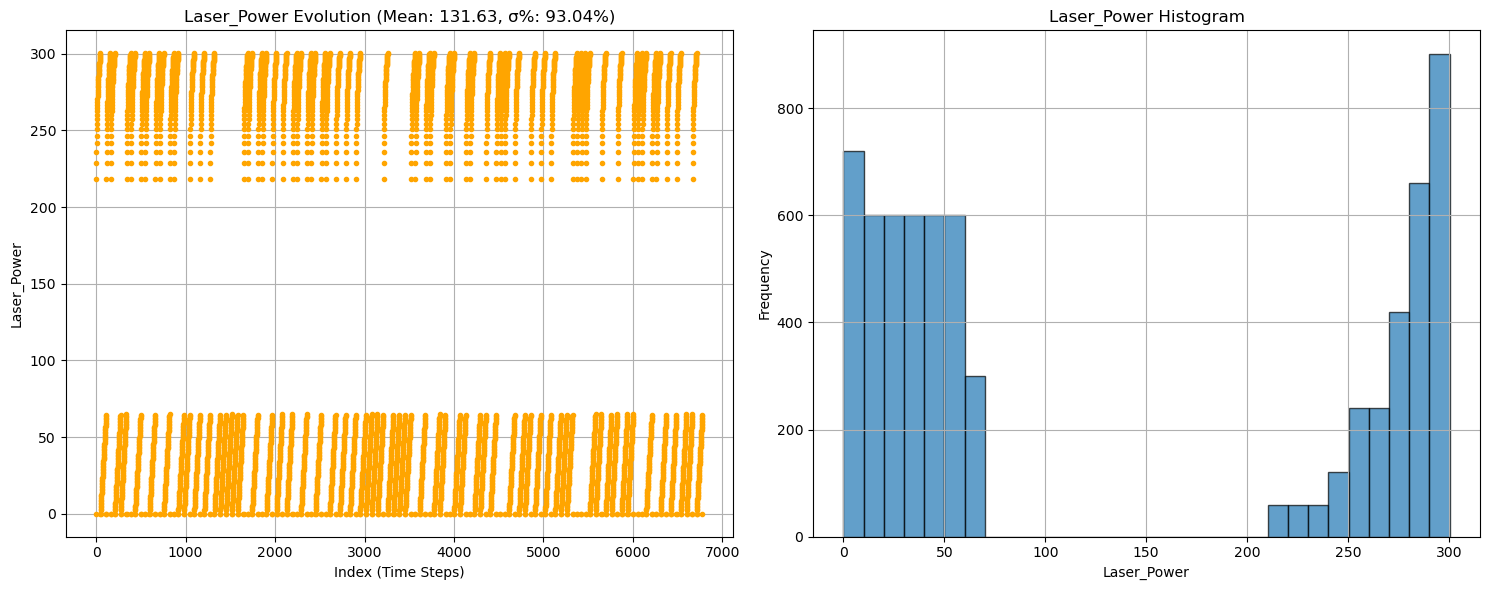

Total_Sum:
  Mean: 159163441.06238937
  Standard Deviation (σ): 95082362.80379857
  Standard Deviation as Percentage of Mean: 59.73882078016138%


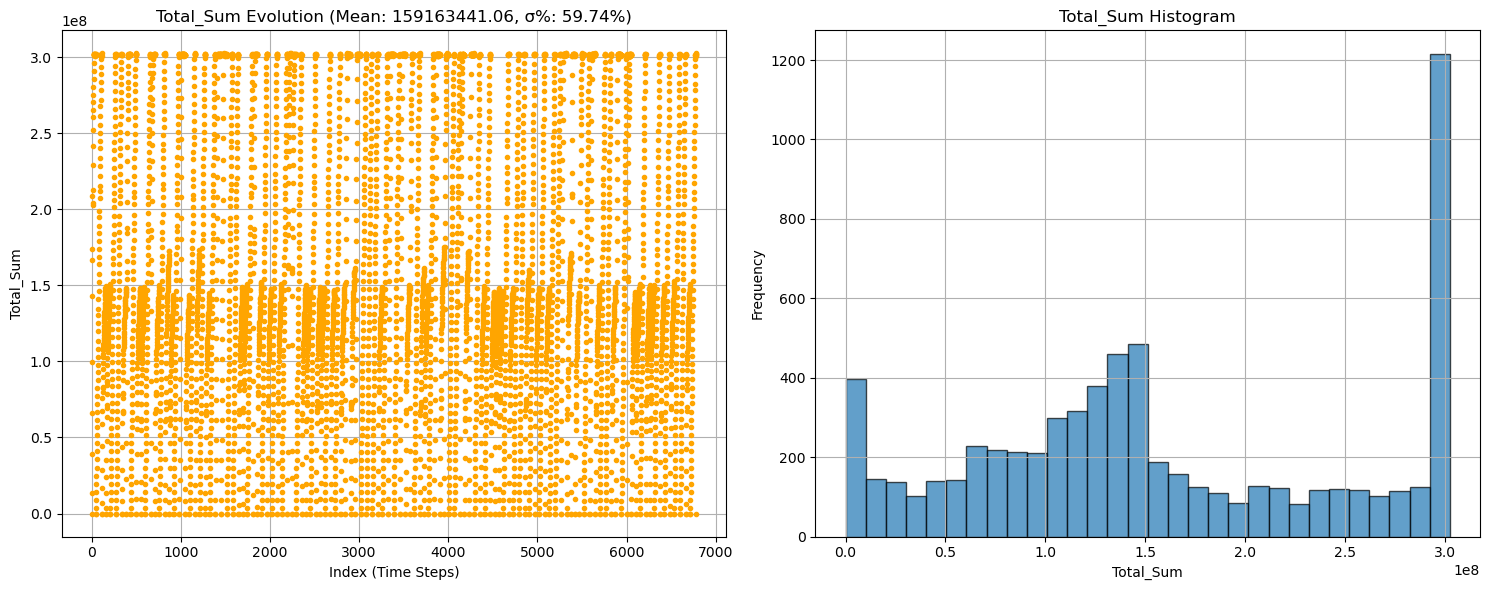

Total_Sqr:
  Mean: 466579266838.4597
  Standard Deviation (σ): 446537437087.7907
  Standard Deviation as Percentage of Mean: 95.70451771539862%


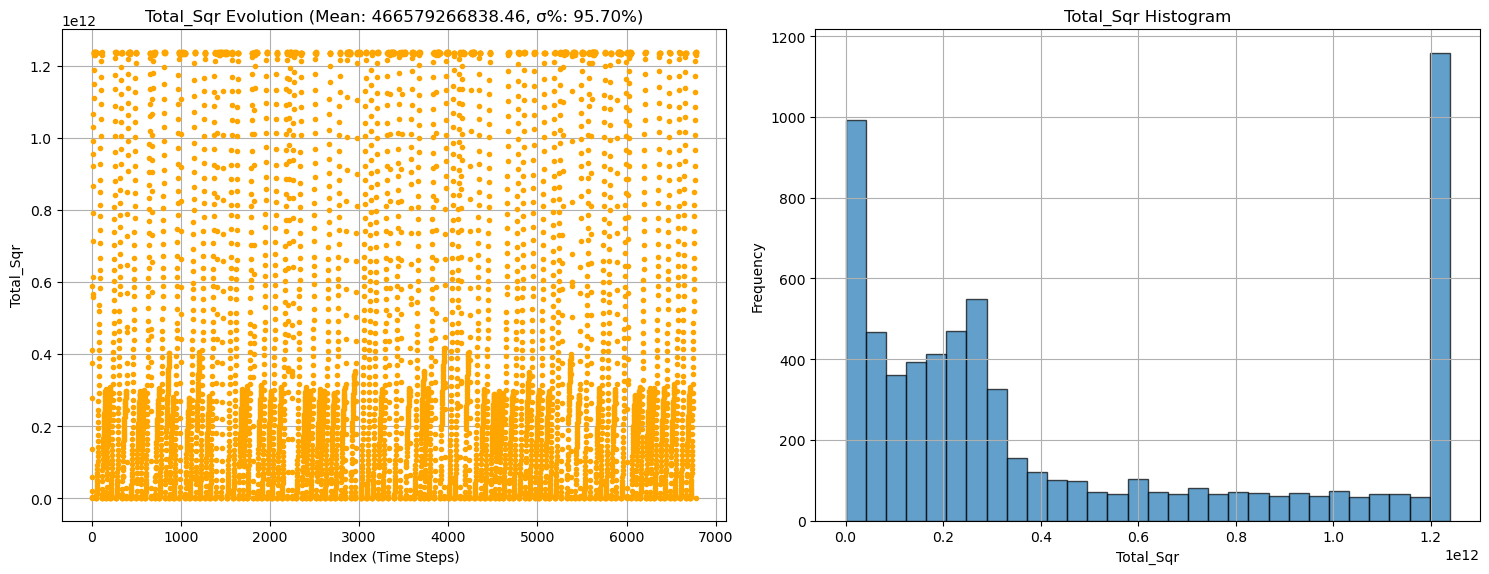

V_Mean:
  Mean: 0.5544281831122418
  Standard Deviation (σ): 0.30459405415539026
  Standard Deviation as Percentage of Mean: 54.93841464652355%


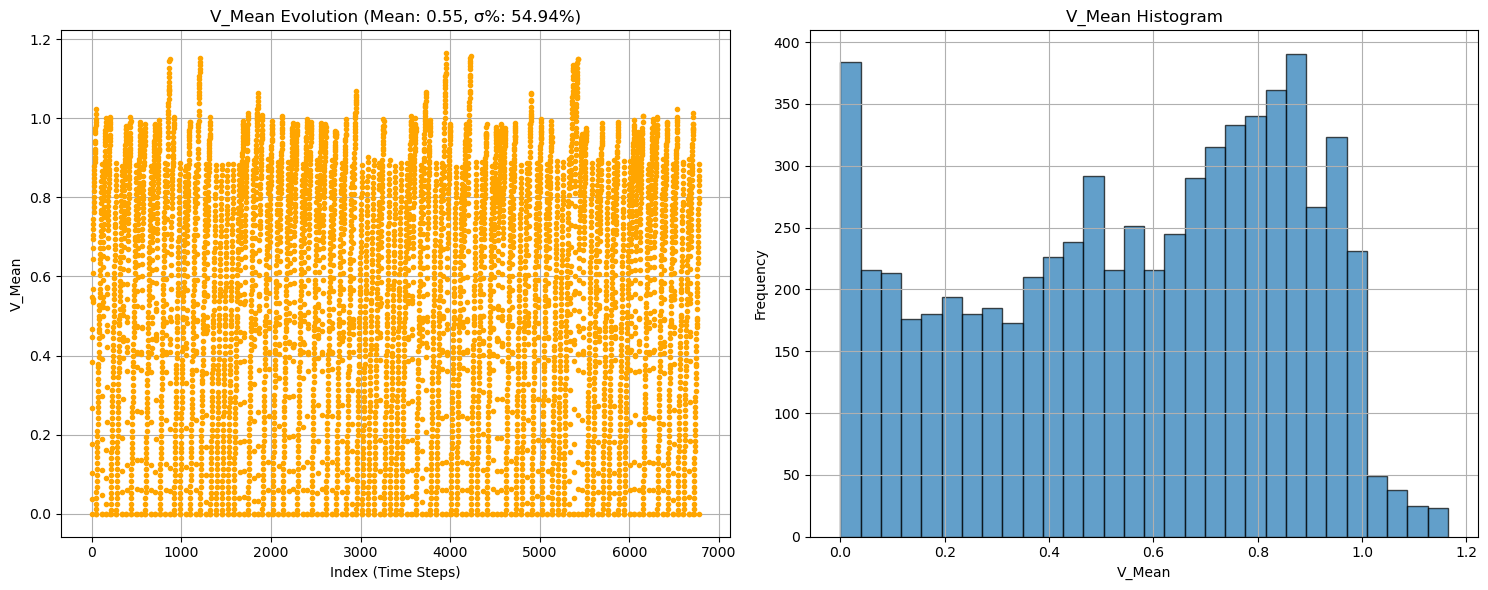

Std_V:
  Mean: 0.0009619948125368733
  Standard Deviation (σ): 0.0014423841143870117
  Standard Deviation as Percentage of Mean: 149.93678714163806%


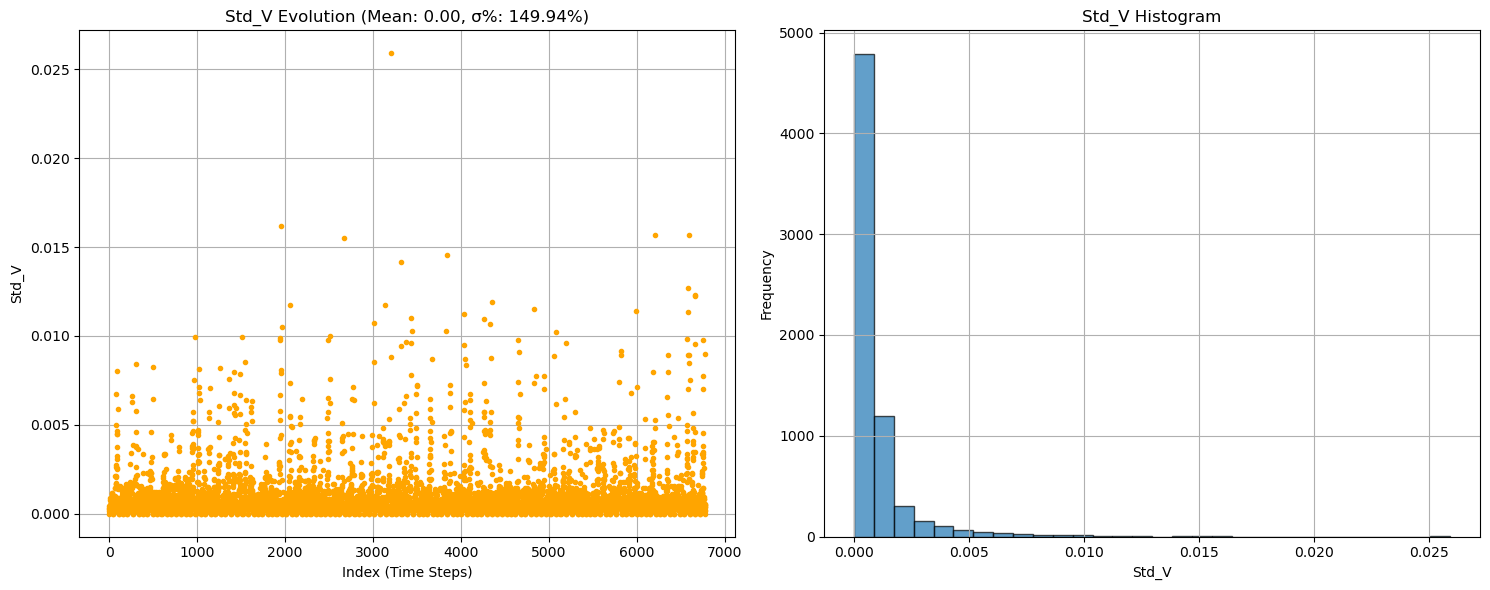

Temp:
  Mean: 21.108997050147494
  Standard Deviation (σ): 0.11826247366571377
  Standard Deviation as Percentage of Mean: 0.5602467676922975%


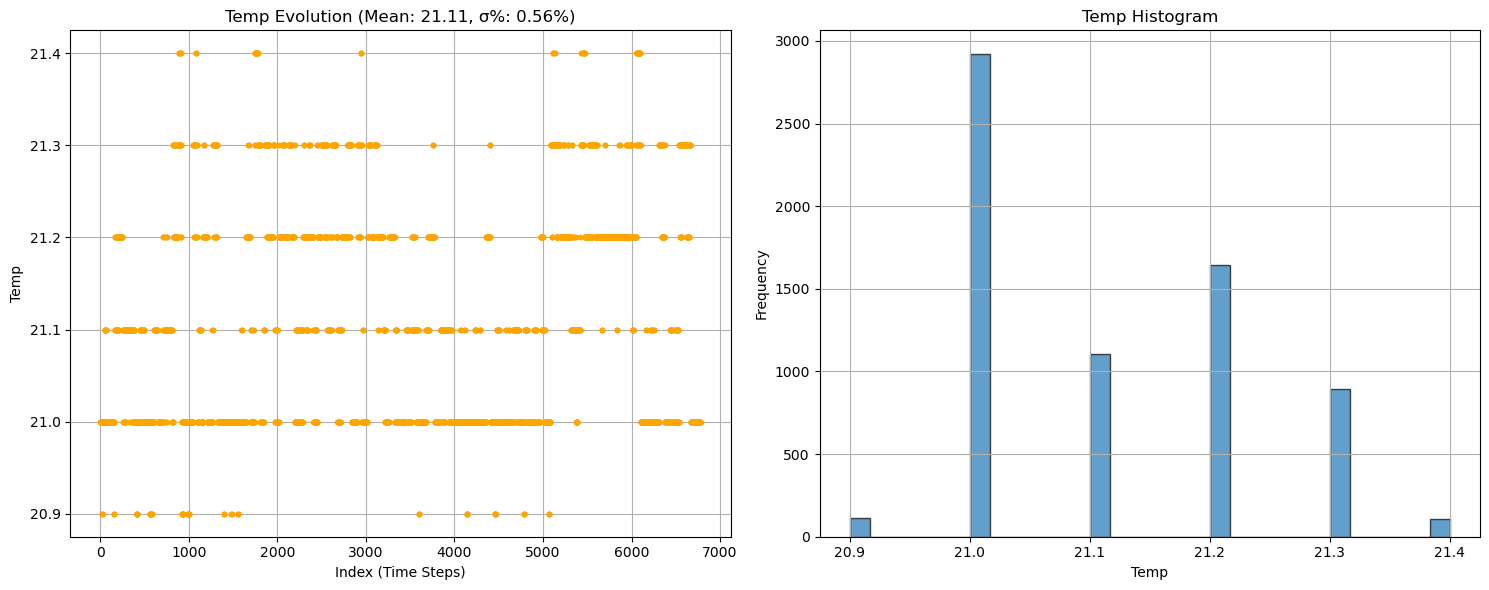

Humidity:
  Mean: 38.36843657817109
  Standard Deviation (σ): 0.542029838416394
  Standard Deviation as Percentage of Mean: 1.4126972239592643%


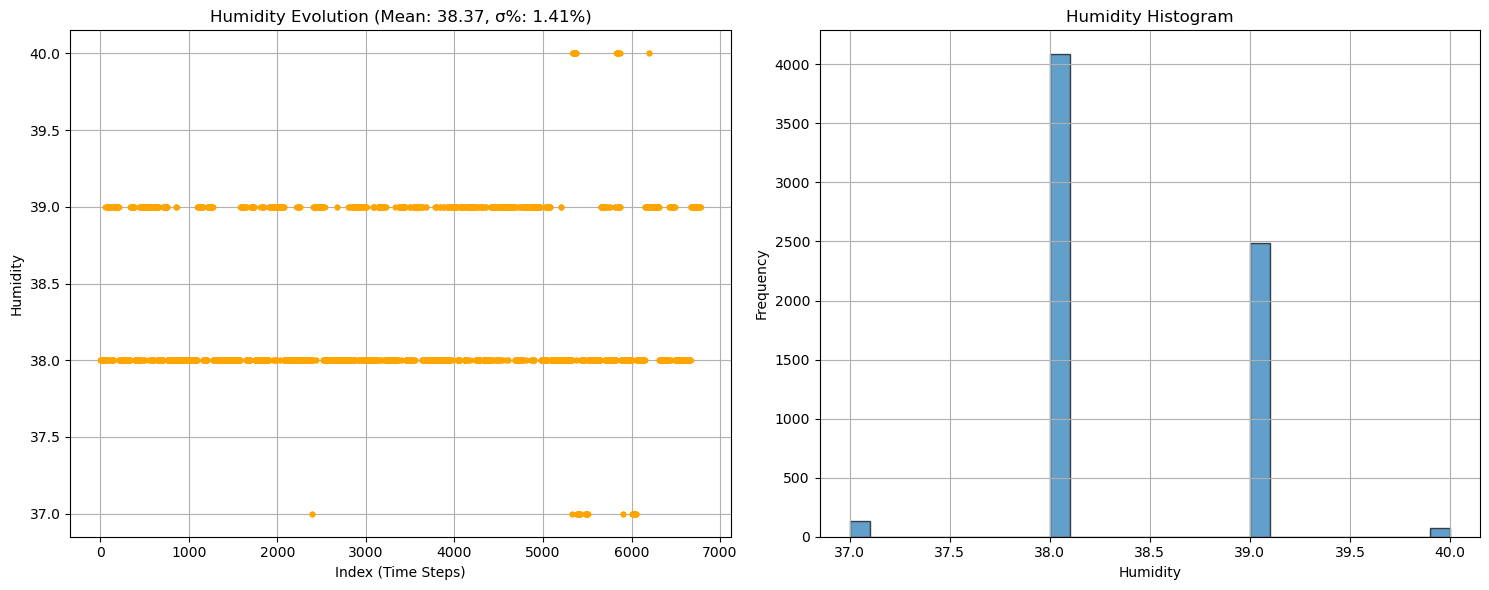

Total_Counts:
  Mean: 73668.75368731564
  Standard Deviation (σ): 95.05370773802066
  Standard Deviation as Percentage of Mean: 0.12902852699459622%


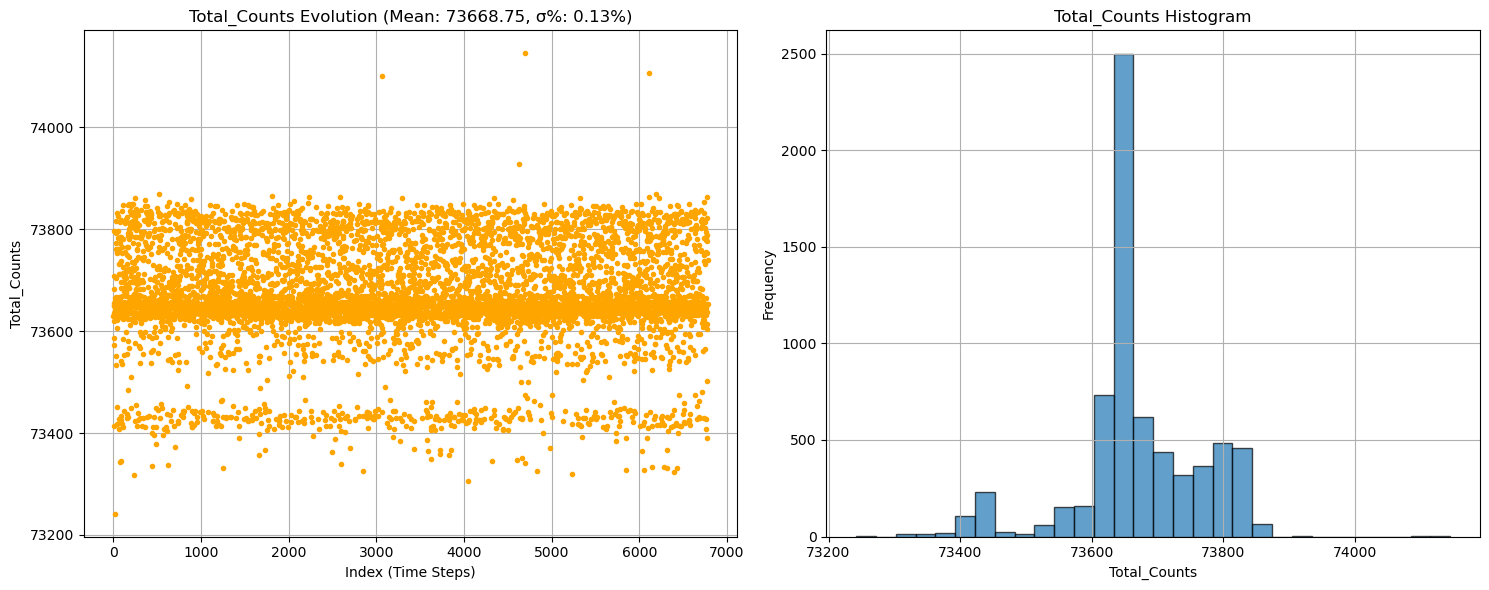

In [41]:
datasets = MergeDatasets('./Data/setup2/28102024_4L2/data')
# Plot each column except 'Date' and 'Time'
columns_to_plot = ['Laser_Power', 'Total_Sum', 'Total_Sqr', 'V_Mean', 'Std_V', 'Temp', 'Humidity', 'Total_Counts']

Overall_Stability(datasets,columns_to_plot)